In [11]:
from importlib import reload
from pyfvtool import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import root
from tqdm import tqdm

import sys
sys.path.append('..')
from pymadreq import *
import pymadreq.coreflood as cf
import pymadreq.fractional_flow as ff
import pymadreq.IO as IO

reload(ff)
reload(cf)
reload(IO)

<module 'pymadreq.IO' from 'c:\\Users\\aaeft\\Documents\\GitHub\\PyMADREQ\\examples\\..\\pymadreq\\IO.py'>

## Reading input file and defining the domain

In [12]:
# read the input file
data = IO.read_json("../examples/sample.json")
rel_perm_ww, rel_perm_ow, pc_ww, pc_ow = IO.read_transport_functions(data)
core_plug = IO.read_core_properties(data)
fluids = IO.read_fluids(data)
IC = IO.read_initial_conditions(data) # initial conditions
BC = IO.createFloodingCondition(data["BC"]) # boundary conditions
numerical_params = IO.read_numerical_settings(data)
m = IO.read_flooding_domain(data)

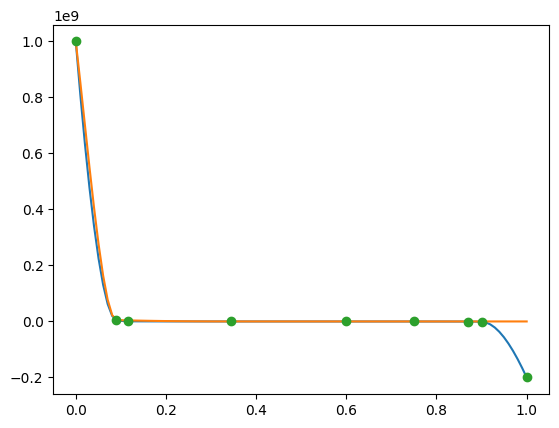

In [13]:
pc_ww.visualize()

In [14]:
cf_1d = cf.CoreFlooding1D(
    rel_perm_ww, pc_ww, core_plug, fluids, IC, BC, numerical_params, Nx=50
)

In [21]:
t_num, R_num, dp_num = cf_1d.simulate_no_pc()
t_num_pc, R_num_pc, dp_num_pc = cf_1d.simulate_with_pc()


## Transport properties

In [16]:
xt_shock, sw_shock, xt_prf, sw_prf, t_ana, p_inj_ana, R_oil_ana = ff.frac_flow_wf(
    fluids, rel_perm_ww, core_plug, IC, ut=cf_1d.u_inj, sw_inj=1.0, pv_inj=3.0)

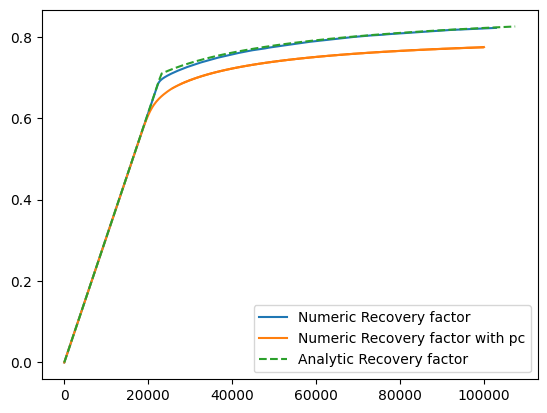

In [17]:
plt.plot(t_num, R_num, label= 'Numeric Recovery factor')
plt.plot(t_num_pc, R_num_pc, label= 'Numeric Recovery factor with pc')
plt.plot(t_ana, R_oil_ana, '--', label= 'Analytic Recovery factor')
plt.legend()

In [18]:
cf_1d.final_sw.value


array([1.15306631, 0.84693369, 0.84522552, 0.84355542, 0.84191895,
       0.84031226, 0.83873197, 0.83717505, 0.83563877, 0.83412061,
       0.83261819, 0.83112925, 0.82965158, 0.82818302, 0.82672136,
       0.82526434, 0.82380962, 0.82235471, 0.82089691, 0.8194333 ,
       0.81796067, 0.81647542, 0.81497351, 0.81345037, 0.81190078,
       0.81031872, 0.80869725, 0.80702828, 0.80530234, 0.80350824,
       0.80163276, 0.79966006, 0.79757109, 0.79534267, 0.79294642,
       0.79034711, 0.78750055, 0.78435062, 0.78082514, 0.77683038,
       0.7722443 , 0.76691033, 0.76063938, 0.75324211, 0.74456054,
       0.73410172, 0.72111949, 0.70427394, 0.68190768, 0.64778449,
       0.62134106, 0.57865894])

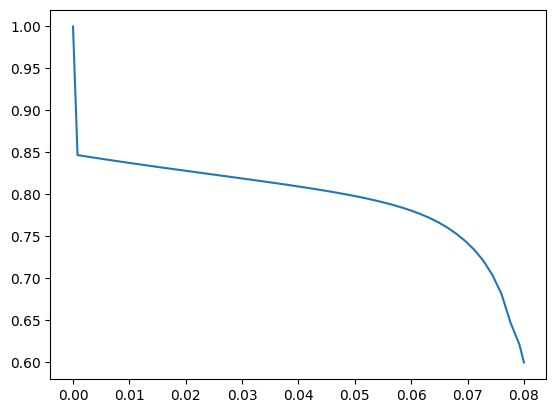

In [19]:
visualizeCells(cf_1d.final_sw)

## Fittin model to core flooding data

In [20]:
# using lmfit to fit a two-phase model to a dataset
from lmfit import minimize, Parameters
def residual(params, x, data):
    amp = params['amp']
    phaseshift = params['phase']
    freq = params['frequency']
    decay = params['decay']

    model = amp * np.sin(x*freq + phaseshift) * np.exp(-x*x*decay)

    return (data-model)


params = Parameters()
params.add('amp', value=10)
params.add('decay', value=0.007)
params.add('phase', value=0.2)
params.add('frequency', value=3.0)

out = minimize(residual, params, args=(x, data))

ModuleNotFoundError: No module named 'lmfit'